# Counterfactual from modelled data

For this scenario we will imagine that we have an application for a new resource consent. The prospective consent holder has modelled a suite of uncertain scenarios for the potential impact of the activity.  Scenario 1 is the expected (most likley) scenario where local groundwater concentrations are expected to show a minimal rise locally to the activity and no rise more distant from the activity.  Scenario 2 is a "trigger case" scenarios, which would trigger changes in the way the activity is managed. This scenario is expected to show more significant rises in groundwater concentrations near the activity and some rise in groundwater concentrations more distant from the activity. 

The question is:
 
**"Given our modelled concentrations for the two scenarios, how frequently will we need to monitor at each location to reliably ensure that our activity is not exceeding the trigger case scenario within the first three years of activity?"**
    
Our input data includes:
- The modelled concentrations for the two scenarios at the near and far well (i.e., from a groundwater model suite)
- monthly monitoring data from the near and far well for the last 3 years

First we will tackle imports and ingest the data:

In [1]:
from komanawa.gw_detect_power import DetectionPowerCounterFactual
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# make /ingest the monitoring data
near_well = pd.Series(index=pd.date_range('2018-01-01', '2021-01-01', freq='M'), data=0)
far_well = pd.Series(index=pd.date_range('2018-01-01', '2021-01-01', freq='M'), data=0)
np.random.seed(684)
near_well += np.random.normal(1.2, 0.3, near_well.shape)
np.random.seed(64)
far_well += np.random.normal(0.8, 0.2, near_well.shape)

# ingest/make the modelled data
near_model_ok_scenario = pd.Series(index=pd.date_range('2021-01-01', '2024-01-01', freq='w'), data=1.2)
adder = np.zeros(near_model_ok_scenario.shape) + np.nan
adder[[0, 10, 23, 44, 57, 61, 74, 85, 104, 120, 150]] = [0, 0.1, 0.4, 0.3, 0.5, 0.2, 0.3, 0.4, 0.5, 0.6, 0.5]
adder = pd.Series(adder).interpolate().values
near_model_ok_scenario = near_model_ok_scenario + adder

near_model_trigger = pd.Series(index=pd.date_range('2021-01-01', '2024-01-01', freq='w'), data=1.2)
adder = np.zeros(near_model_ok_scenario.shape) + np.nan
adder[[0, 10, 23, 44, 57, 61, 74, 85, 104, 120, 150]] = [0, 0.1, 0.4, 0.6, 0.8, 0.7, 0.9, 1.1, 0.9, 1.2, 1.1]
adder = pd.Series(adder).interpolate().values
near_model_trigger = near_model_trigger + adder

far_model_ok_scenario = pd.Series(index=pd.date_range('2021-01-01', '2024-01-01', freq='w'), data=0.8)
adder = np.zeros(near_model_ok_scenario.shape) + np.nan
adder[[0, 10, 23, 44, 57, 61, 74, 85, 104, 120, 150]] = [0, 0.1, 0.3, 0.2, 0.3, 0.4, 0.3, 0.2, 0.3, 0.4, 0.3]
adder = pd.Series(adder).interpolate().values
far_model_ok_scenario = far_model_ok_scenario + adder

far_model_trigger = pd.Series(index=pd.date_range('2021-01-01', '2024-01-01', freq='w'), data=0.8)
adder = np.zeros(near_model_ok_scenario.shape) + np.nan
adder[[0, 10, 23, 44, 57, 61, 74, 85, 104, 120, 150]] = [0, 0.2, 0.5, 0.5, 0.6, 0.8, 0.6, 0.8, 0.9, 0.8, 0.9]
adder = pd.Series(adder).interpolate().values
far_model_trigger = far_model_trigger + adder

## Examine the monitoring data

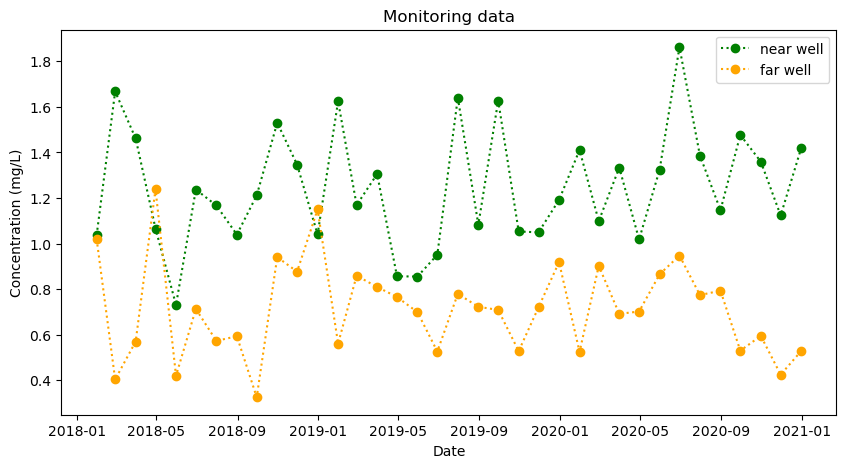

In [2]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(near_well.index, near_well.values, label='near well', color='green', marker='o', ls=':')
ax.plot(far_well.index, far_well.values, label='far well', color='orange', marker='o', ls=':')
ax.legend()
ax.set_ylabel('Concentration (mg/L)')
ax.set_xlabel('Date')
ax.set_title('Monitoring data')
plt.show()

There does not appear to be any trend in the monitoring data, so we can simply estimate the noise as the standard deviation of the data.

In [3]:
noise_near = near_well.std()
noise_far = far_well.std()
print(f'Noise near well: {noise_near:.2f} mg/L')
print(f'Noise far well: {noise_far:.2f} mg/L')

Noise near well: 0.26 mg/L
Noise far well: 0.21 mg/L


## Examine the modelled data

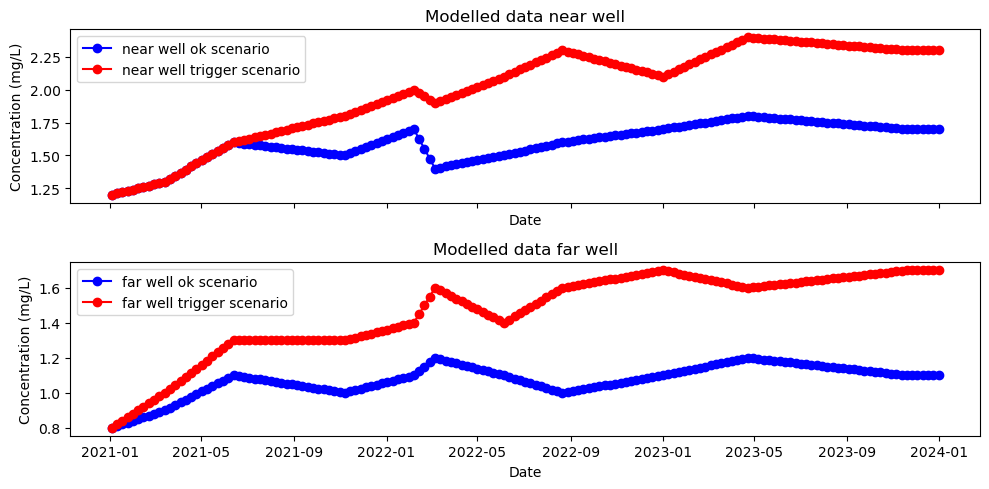

In [4]:
fig, (ax_near, ax_far) = plt.subplots(nrows=2, sharex=True, figsize=(10, 5))

ax_near.plot(near_model_ok_scenario.index, near_model_ok_scenario.values, label='near well ok scenario', color='blue',
             marker='o')
ax_near.plot(near_model_trigger.index, near_model_trigger.values, label='near well trigger scenario', color='red',
             marker='o')
ax_near.legend()
ax_near.set_ylabel('Concentration (mg/L)')
ax_near.set_xlabel('Date')
ax_near.set_title('Modelled data near well')

ax_far.plot(far_model_ok_scenario.index, far_model_ok_scenario.values, label='far well ok scenario', color='blue',
            marker='o')
ax_far.plot(far_model_trigger.index, far_model_trigger.values, label='far well trigger scenario', color='red',
            marker='o')
ax_far.legend()
ax_far.set_ylabel('Concentration (mg/L)')
ax_far.set_xlabel('Date')
ax_far.set_title('Modelled data far well')

fig.tight_layout()
plt.show()

## Calculate the detection power and identify the required monitoring frequency for the near well

In [5]:
dpc = DetectionPowerCounterFactual(significance_mode='wilcoxon-signed-rank-test', alternative='alt>base', min_samples=4)

xdata = (near_model_trigger.index - near_model_trigger.index.min()).days / 365  # make years from start of activity array
near_well_ok_sampler = interp1d(xdata, near_model_ok_scenario.values)
near_well_trigger_sampler = interp1d(xdata, near_model_trigger.values)

samp_years = [1, 2, 3]
samp_freqs = [4, 12, 26, 52, 104]
samp_colors = ['grey', 'lightcoral', 'orangered', 'steelblue', 'purple']

near_power = []

for samp_year in samp_years:
    for samp_freq in samp_freqs:
        near_power.append(dpc.power_calc(
            idv=f'{samp_year}-{samp_freq}',
            error_base=noise_near,
            true_conc_base=near_well_ok_sampler(np.arange(0, samp_year, 1 / samp_freq)),
            true_conc_alt=near_well_trigger_sampler(np.arange(0, samp_year, 1 / samp_freq)),
            error_alt=None,  # same error as base
            seed_base=987,
            seed_alt=228,
            samp_year=samp_year,  # pass straight through
            samp_freq=samp_freq,  # pass straight through
        ))

near_power = pd.DataFrame(near_power)


## Calculate the detection power and identify the required monitoring frequency for the far well

In [6]:
xdata = (far_model_trigger.index - far_model_trigger.index.min()).days / 365  # make years from start of activity array
far_well_ok_sampler = interp1d(xdata, far_model_ok_scenario.values)
far_well_trigger_sampler = interp1d(xdata, far_model_trigger.values)

far_power = []
for samp_year in samp_years:
    for samp_freq in samp_freqs:
        far_power.append(dpc.power_calc(
            idv=f'{samp_year}-{samp_freq}',
            error_base=noise_far,
            true_conc_base=far_well_ok_sampler(np.arange(0, samp_year, 1 / samp_freq)),
            true_conc_alt=far_well_trigger_sampler(np.arange(0, samp_year, 1 / samp_freq)),
            error_alt=None,  # same error as base
            seed_base=6548,
            seed_alt=57,
            samp_year=samp_year,  # pass straight through
            samp_freq=samp_freq,  # pass straight through
        ))
far_power = pd.DataFrame(far_power)

## Results

We can then plot the results of the detection power calculations for the near and far wells.

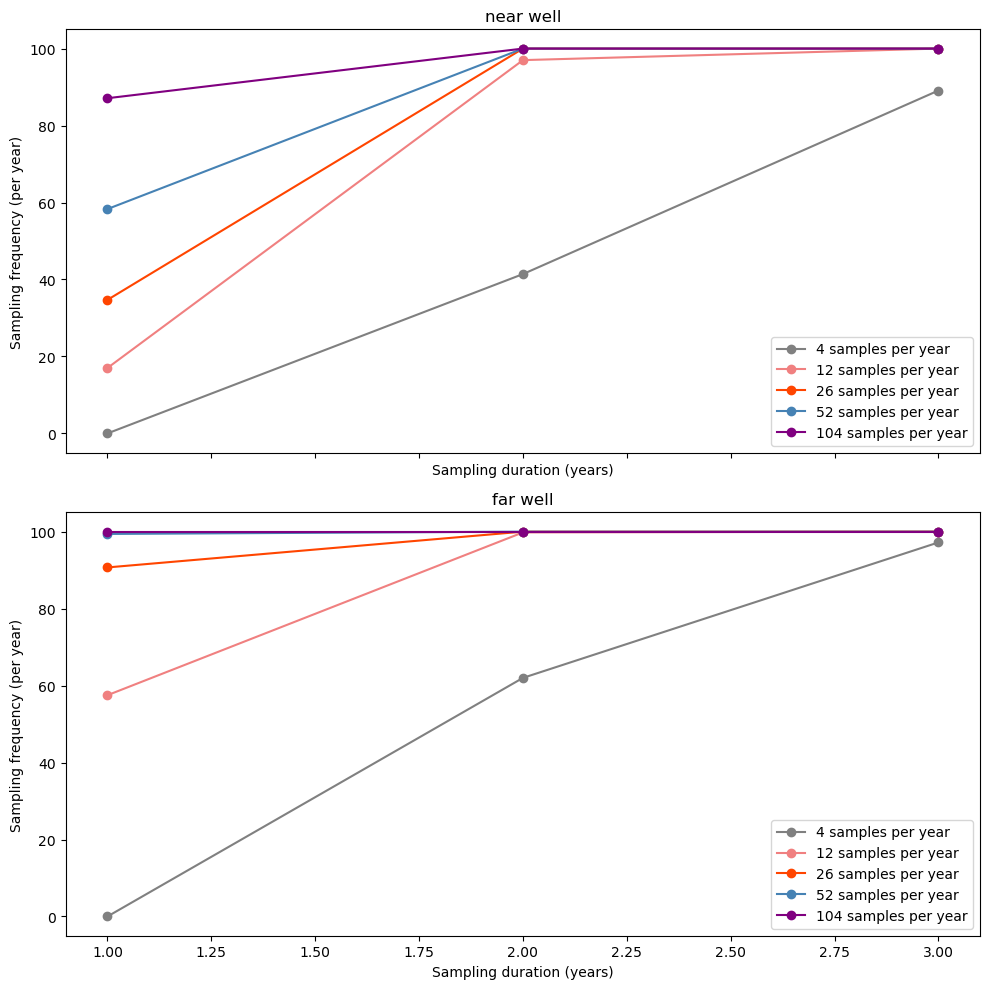

In [7]:
fig, (ax_near, ax_far) = plt.subplots(nrows=2, sharex=True, figsize=(10, 10))

for ax, power, well in zip([ax_near, ax_far], [near_power, far_power], ['near', 'far']):
    for samp_freq, c in zip(samp_freqs, samp_colors):
        temp = power[power['samp_freq'] == samp_freq]
        ax.plot(temp['samp_year'], temp['power'], marker='o', color=c, label = f'{samp_freq} samples per year')
    ax.set_ylabel('Sampling frequency (per year)')
    ax.set_xlabel('Sampling duration (years)')
    ax.set_title(f'{well} well')
    ax.legend()
    
fig.tight_layout()
plt.show()

## Discussion

From these results we can see that the far well is a much better detector of the trigger case scenario than the near well.  We can also clearly see that quarterly sampling would be insufficient, but that the current monthly sampling should be sufficient. Sampling the far well at fortnightly, could allow the prospective consent holder to assuage any concerns about the activity within a year, which, depending on the nature of the activity, may be a worthwhile investment.